<DIV align="justify">Buying a laptop is a decision almost all of us have made at some time. Each of us tries to have the best equipment at the lowest possible price, but it is known that more expensive components make the price of the equipment increase. But which component affects the price the most? Using the laptop database, we will try to answer this question by exploring and creating a model of neural networks (regression, because we predict the price) explaining the price of the laptop depending on its components. We will try to estimate what influences the price of the finished set the most and how accurately we are able to forecast laptop prices based on its components. Enjoy reading!</DIV>

In [20]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K
import eli5
from eli5.sklearn import PermutationImportance
from tensorflow.keras.layers import Dropout


plt.rcParams["figure.figsize"] = (18, 11.5)
plt.style.use('bmh')
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'#f0f0f0'})

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

def plot_box(x, y, xlabel, ylabel, title, subtitle, color, title_position, subtitle_position, order=None):
    ax = sns.boxplot(data = df, y = y, x = x, order = order,
                 linewidth = 1.2, color = color, **PROPS,
                 flierprops = dict(marker = 'o', markeredgecolor = 'black', markersize = 6.5, linestyle = 'none', markerfacecolor = color, alpha = 0.9))

    plt.xlabel(xlabel, fontweight = 'bold', fontsize = 16)
    plt.ylabel(ylabel, fontweight = 'bold', fontsize = 16)
    ax.tick_params(labelsize = 14)
    ax.text(x = title_position, y = 1.07, s = title, fontsize = 22.5, weight = 'bold', ha = 'center', va = 'bottom', transform = ax.transAxes)
    ax.text(x = subtitle_position, y = 1.03, s = subtitle, fontsize = 16.5, alpha = 0.75, ha = 'center', va = 'bottom', transform = ax.transAxes)
    plt.show()

def plot_scatter(x, y, xlabel, ylabel, title, subtitle, color, title_position, subtitle_position, size, alpha):
    ax = sns.scatterplot(data = df, y = y, x = x,
                 linewidth = 1.2, color = color, s = size, alpha = alpha, marker = "o", edgecolor = "black")

    plt.xlabel(xlabel, fontweight = 'bold', fontsize = 16)
    plt.ylabel(ylabel, fontweight = 'bold', fontsize = 16)
    ax.text(x = title_position, y = 1.07, s = title, fontsize = 22.5, weight = 'bold', ha = 'center', va = 'bottom', transform = ax.transAxes)
    ax.text(x = subtitle_position, y = 1.03, s = subtitle, fontsize = 16.5, alpha = 0.75, ha = 'center', va = 'bottom', transform = ax.transAxes)
    plt.show()

<DIV align="justify">For the analysis, we will use Python in its latest version. We'll use pandas, numpy and re packages for data manipulation, matplotlib and seaborn for data visualization, and tensorflow and keras for creating a neural network model. At the beginning, we will also define functions for creating charts (in this case, boxplots and scatterplots, because we will use them because they will best show the relationships between the explained features and the price) to improve work, reduce the amount of code and ensure consistency between the charts.</DIV>

In [3]:
df = pd.read_csv('../input/laptop-price/laptop_price.csv')
df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


<DIV align="justify">The database contains 1303 rows and 13 variables. Each line corresponds to one laptop and the columns describe its components such as the company producing the hardware, product name, device type, screen size in inches, screen resolution, CPU, RAM, Memory, GPU, operating system, hardware weight and price. Data doesn't contain gaps but will require preparation for modeling (e.g. format change, recoding, removal of unnecessary variables). We start with data exploration, checking the price in turn depending on each feature of the laptop.</DIV>

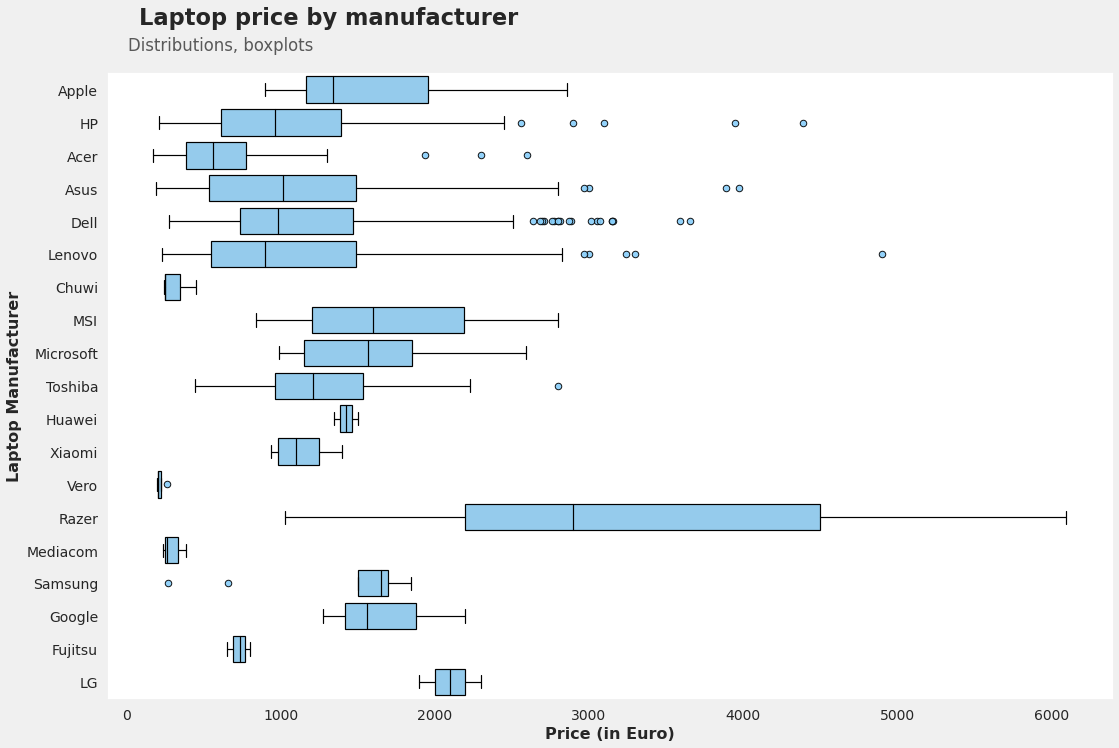

In [4]:
plot_box(x = "Price_euros", y = "Company", xlabel = 'Price (in Euro)', ylabel = "Laptop Manufacturer", title = "Laptop price by manufacturer",
         subtitle = "Distributions, boxplots", color = "lightskyblue", title_position = 0.22, subtitle_position = 0.112)

<DIV align="justify">We start with manufacturers - out of over 1,300 laptops, 19 products can be distinguished, the most popular of which are Dell and Lenovo (297 devices each). Razer equipment has the highest median price - almost 3,000 euros, but you have to remember about a small sample of laptops from this company (only 7). Chuwi, Vero and Medicom have the cheapest devices on their offer. Distribution of the sprinkler prices are regular for most brands, but some of them have unusual values due to the high price (premium products compared to others), in Lenovo or HP for example. The company that produces the equipment seems to be a variable that can vary the price, not only after looking at the chart, but also knowing the strength of brand and recognition.</DIV>

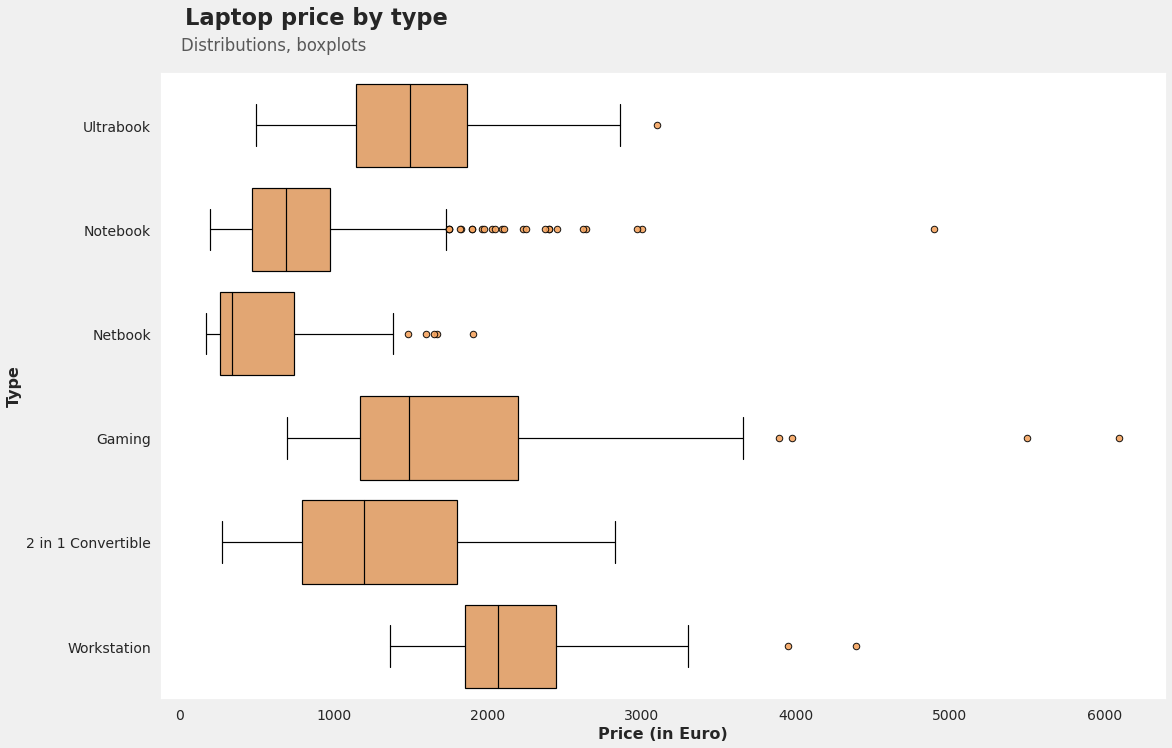

In [5]:
plot_box(x = "Price_euros", y = "TypeName", xlabel = 'Price (in Euro)', ylabel = "Type", title =  "Laptop price by type",
         subtitle = "Distributions, boxplots", color = "sandybrown", title_position = 0.155, subtitle_position = 0.113)

<DIV align="justify">In the next chart, we look at the distributions by type of equipment. There are 6 types of devices in the database, the most popular of which is a notebook (over 50%). Notebooks and netbooks have the lowest average price on average, while the workstation has the highest average price. The high price can also be noted in gaming equipment (not only a large median, but also both laptops with a price of more than 5,000 belong to this category), which results from the high price for decent graphics cards, which are an inseparable element of such laptops. The type of equipment may affect the price, but we suspect the apparent correlation (workstations or gaming usually have better components than notebooks).</DIV>

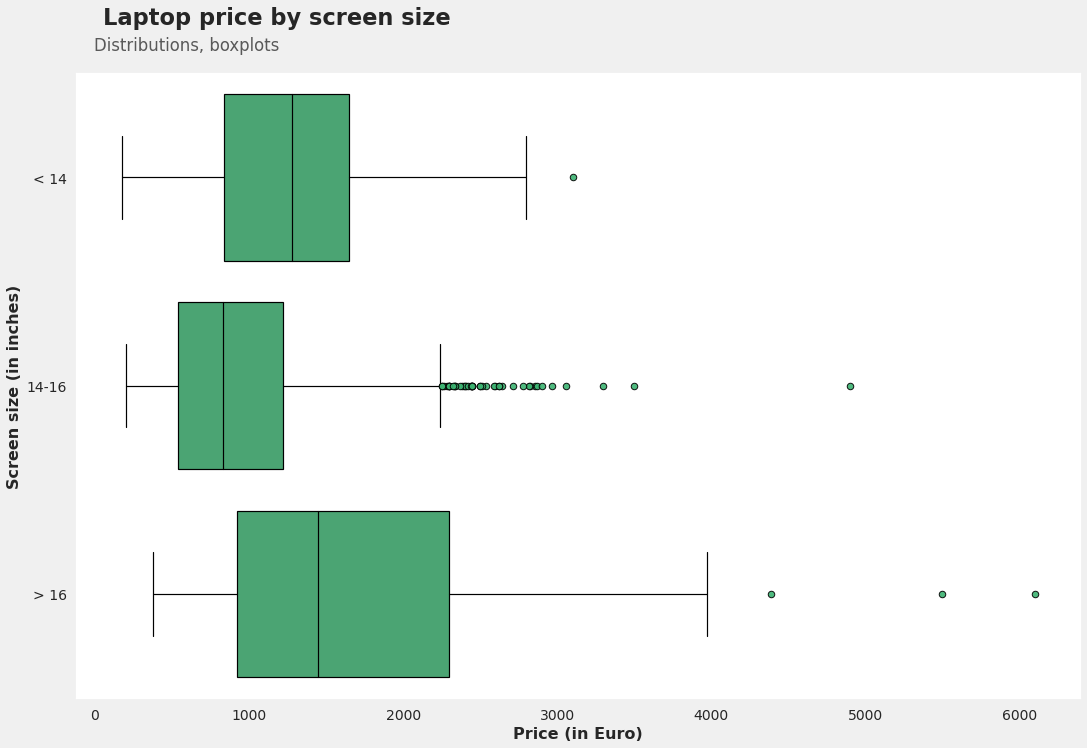

In [6]:
conditions = [
    (df["Inches"].lt(14)),
    (df["Inches"].ge(14) & df["Inches"].lt(16)),
    (df["Inches"].ge(16)),
]
choices = ["< 14", "14-16", "> 16"]

df["Inches"] = np.select(conditions, choices)

plot_box(x = "Price_euros", y = "Inches", xlabel = 'Price (in Euro)', ylabel = "Screen size (in inches)", title = "Laptop price by screen size",
         subtitle = "Distributions, boxplots", color = "mediumseagreen", order = ["< 14", "14-16", "> 16"], title_position = 0.2,
         subtitle_position = 0.11)

<DIV align="justify">Another potential predictor of a laptop's price is screen size. It is a quantitative variable, however, most laptops are fixed size (e.g. 13.3, 15.6) so it is stepwise. We recode this variable into 3 categories: up to 14 inches, between 14 and 16 inches and over 16 inches, thus obtaining 3 classes (each of them represents at least 10% of the population). It turns out that the quadrant distribution has the lowest values in laptops with screens ranging from 14 to 16 inches. The most expensive laptops have screens over 16 inches (right-hand price distribution in this category, which means that we will find a lot of lapots in this category also at low prices). The variable is not a simulator or a destimulant, but appears to have a moderate effect on the model.</DIV>

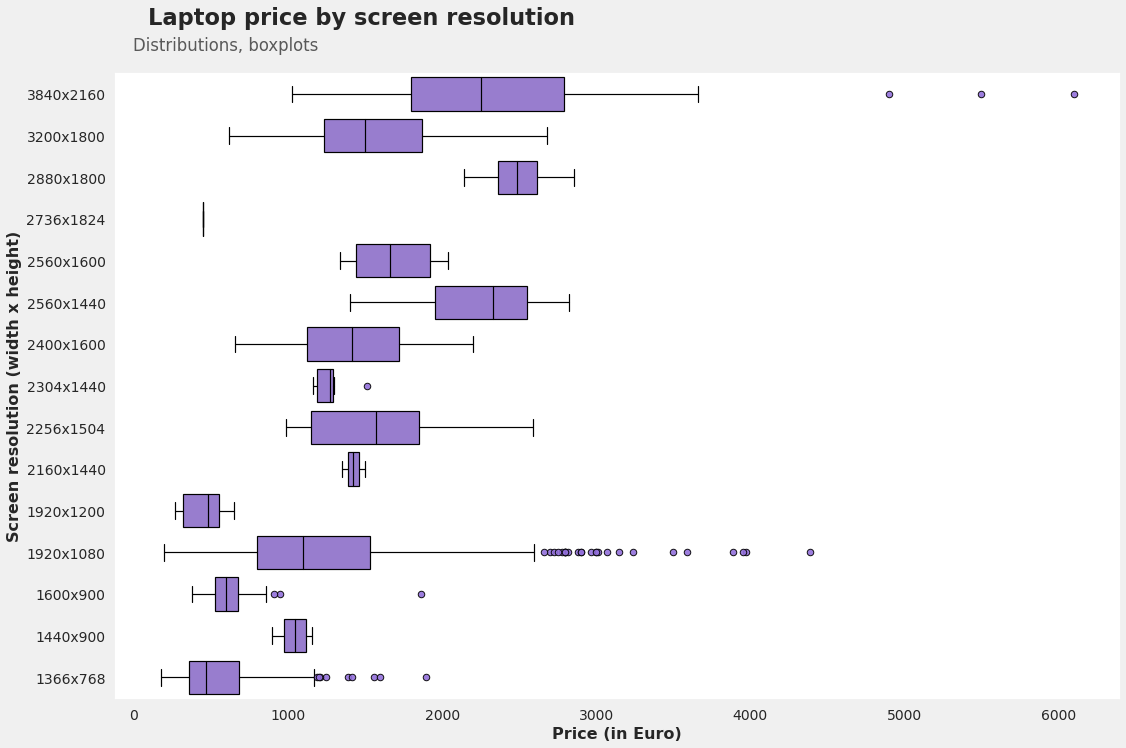

In [7]:
df["ScreenResolution"] = df["ScreenResolution"].astype('string')
df["ScreenResolution"] = df["ScreenResolution"].str.replace('4K', '', regex=True)
df["ScreenResolution"] = df["ScreenResolution"].str.replace('\D', '', regex=True)

def insert_dash(string, index):
    return string[:index] + 'x' + string[index:]

i = 0

for i in range(0,len(df["ScreenResolution"])):
    df["ScreenResolution"][i] = insert_dash(df["ScreenResolution"][i],4)
    i = i +1

plot_box(x = "Price_euros", y = "ScreenResolution", xlabel = 'Price (in Euro)', ylabel = "Screen resolution (width x height)", title = "Laptop price by screen resolution",
         subtitle = "Distributions, boxplots", color = "mediumpurple", title_position = 0.245, subtitle_position = 0.11,
         order = ["3840x2160", "3200x1800", "2880x1800", "2736x1824", "2560x1600", "2560x1440", "2400x1600", "2304x1440", "2256x1504", "2160x1440", 
                  "1920x1200", "1920x1080","1600x900", "1440x900", "1366x768"])

<DIV align="justify">Speaking of the screen, it's time for resolution. It depends on the size and shape of the screen, but the higher the screen, the better the image quality. The resolution is given in the "Width x Height" format. In the database of over 1,300 laptops, 15 different resolutions have been selected and the price distributions are diminishing. Thus, we can see that the intuitive conclusion that the higher the screen resolution, the higher the average price is confirmed (the variable is a stimulant). FullHD (1920x1080) quality is the most popular, and the lowest price is that of the worst resolution, HD (1366x768).</DIV>

In [8]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

df["ScreenWidth"] = ""

for i in range(0, len(df["ScreenResolution"])):
    df["ScreenWidth"][i] = df["ScreenResolution"][i][:4]
    i = i +1
    
df["ScreenWidth"] = df["ScreenWidth"].astype('int')

df["ScreenHeight"] = ""

for i in range(0, len(df["ScreenResolution"])):
    df["ScreenHeight"][i] = df["ScreenResolution"][i][5:]
    i = i +1
    
df["ScreenHeight"] = df["ScreenHeight"].astype('int')

del df['ScreenResolution']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<DIV align="justify">From this categorical variable we create two quantitative variables: screen resolution width and height. They will be correlated with each other, but in this form it seems that they should have a better impact on the model than a qualitative variable with as many as 15 categories.</DIV>

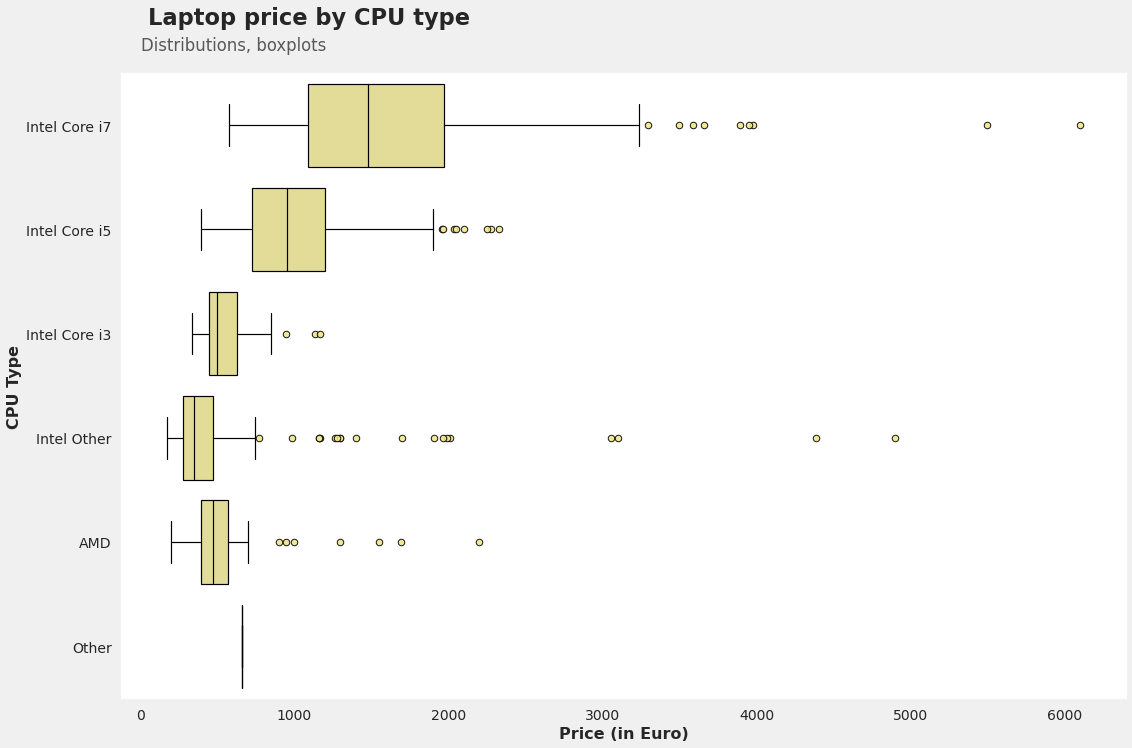

In [9]:
df['Cpu'] = df['Cpu'].replace(['Intel Core i7 7700HQ 2.8GHz', 'Intel Core i7 7500U 2.7GHz', 'Intel Core i7 8550U 1.8GHz', 'Intel Core i7 6920HQ 2.9GHz',
                              'Intel Core i7 2.7GHz', 'Intel Core i7 6500U 2.5GHz', 'Intel Core i7 6700HQ 2.6GHz', 'Intel Core i7 6560U 2.2GHz',
                              'Intel Core i7 2.9GHz', 'Intel Core i7 6600U 2.6GHz', 'Intel Core i7 7600U 2.8GHz', 'Intel Core i7 6820HK 2.7GHz',
                              'Intel Core i7 7820HK 2.9GHz', 'Intel Core i7 6820HQ 2.7GHz', 'Intel Core i7 7Y75 1.3GHz', 'Intel Core i7 7820HQ 2.9GHz',
                              'Intel Core i7 7660U 2.5GHz', 'Intel Core i7 6500U 2.50GHz', 'Intel Core i7 7500U 2.5GHz', 'Intel Core i7 2.2GHz', 'Intel Core i7 2.8GHz',
                              'Intel Core i7 7560U 2.4GHz', 'Intel Core i7 8650U 1.9GHz', 'Intel Core i7 7700HQ 2.7GHz'], 'Intel Core i7')
df['Cpu'] = df['Cpu'].replace(['Intel Core i5 7200U 2.5GHz', 'Intel Core i5 8250U 1.6GHz', 'Intel Core i5 7200U 2.50GHz', 'Intel Core i5 2.9GHz', 'Intel Core i5 7300U 2.6GHz',
                              'Intel Core i5 6440HQ 2.6GHz', 'Intel Core i5 6200U 2.3GHz', 'Intel Core i5 7300HQ 2.5GHz', 'Intel Core i5 2.0GHz', 'Intel Core i5 6300U 2.4GHz',
                              'Intel Core i5 6300HQ 2.3GHz', 'Intel Core i5 7440HQ 2.8GHz', 'Intel Core i5 7Y54 1.2GHz', 'Intel Core i5 1.6GHz', 'Intel Core i5 1.8GHz',
                              'Intel Core i5 3.1GHz', 'Intel Core i5 1.3GHz', 'Intel Core i5 7200U 2.7GHz', 'Intel Core i5 2.3GHz', 'Intel Core i5 7Y57 1.2GHz',
                              'Intel Core i5 6260U 1.8GHz', 'Intel Core i5 7500U 2.7GHz', 'Intel Core i5 7200U 2.70GHz'], 'Intel Core i5')
df['Cpu'] = df['Cpu'].replace(['Intel Core i3 6006U 2GHz', 'Intel Core i3 7100U 2.4GHz', 'Intel Core i3 6006U 2.0GHz', 'Intel Core i3 6100U 2.3GHz', 'Intel Core i3 7130U 2.7GHz',
                              'Intel Core i3 6100U 2.1GHz', 'Intel Core i3 6006U 2.2GHz'], 'Intel Core i3')
df['Cpu'] = df['Cpu'].replace(['Intel Pentium Dual Core 4405U 2.1GHz', 'Intel Core M m3-7Y30 2.2GHz', 'Intel Core M 7Y30 1.0GHz', 'Intel Core M 6Y54 1.1GHz',
                              'Intel Pentium Dual Core N4200 1.1GHz', 'Intel Celeron Quad Core N3710 1.6GHz', 'Intel Core M M3-6Y30 0.9GHz', 'Intel Celeron Dual Core N3350 1.1GHz',
                              'Intel Atom Z8350 1.92GHz', 'Intel Celeron Dual Core N3350 1.1GHz', 'Intel Celeron Dual Core N3060 1.6GHz', 'Intel Pentium Quad Core N4200 1.1GHz',
                              'Intel Pentium Quad Core N3710 1.6GHz', 'Intel Celeron Dual Core N3050 1.6GHz', 'Intel Celeron Quad Core N3450 1.1GHz',
                              'Intel Atom x5-Z8350 1.44GHz', 'Intel Core M 6Y75 1.2GHz', 'Intel Celeron Dual Core 3205U 1.5GHz', 'Intel Atom x5-Z8550 1.44GHz',
                              'Intel Celeron Dual Core 3855U 1.6GHz', 'Intel Core M 6Y30 0.9GHz', 'Intel Xeon E3-1505M V6 3GHz', 'Intel Core M 1.2GHz',
                              'Intel Pentium Quad Core N3700 1.6GHz', 'Intel Celeron Dual Core N3060 1.60GHz', 'Intel Core M m7-6Y75 1.2GHz', 'Intel Celeron Dual Core N3350 2.0GHz',
                              'Intel Atom x5-Z8300 1.44GHz', 'Intel Core M m3 1.2GHz', 'Intel Xeon E3-1535M v5 2.9GHz', 'Intel Celeron Dual Core N3350 2GHz',
                              'Intel Atom X5-Z8350 1.44GHz', 'Intel Core M M7-6Y75 1.2GHz', 'Intel Xeon E3-1535M v6 3.1GHz', 'Intel Pentium Dual Core 4405Y 1.5GHz',
                              'Intel Core M 1.1GHz', 'Intel Celeron Quad Core N3160 1.6GHz'], 'Intel Other')
df['Cpu'] = df['Cpu'].replace(['AMD E-Series 9000e 1.5GHz', 'AMD E-Series E2-6110 1.5GHz', 'AMD E-Series 9000 2.2GHz', 'AMD Ryzen 1600 3.2GHz', 'AMD A9-Series 9420 3GHz',
                              'AMD A6-Series 9220 2.5GHz', 'AMD A12-Series 9720P 3.6GHz', 'AMD A8-Series 7410 2.2GHz', 'AMD A9-Series 9410 2.9GHz', 'AMD Ryzen 1700 3GHz',
                              'AMD A12-Series 9700P 2.5GHz', 'AMD A4-Series 7210 2.2GHz', 'AMD FX 9830P 3GHz', 'AMD E-Series E2-9000 2.2GHz', 'AMD A6-Series 7310 2GHz',
                              'AMD E-Series 6110 1.5GHz', 'AMD A9-Series A9-9420 3GHz', 'AMD A12-Series 9720P 2.7GHz', 'AMD E-Series 7110 1.8GHz', 'AMD FX 8800P 2.1GHz',
                              'AMD A6-Series 9220 2.9GHz', 'AMD A9-Series 9420 2.9GHz', 'AMD A10-Series 9600P 2.4GHz', 'AMD E-Series E2-9000e 1.5GHz', 'AMD A10-Series A10-9620P 2.5GHz',
                              'AMD A6-Series A6-9220 2.5GHz', 'AMD A10-Series 9620P 2.5GHz'], 'AMD')
df['Cpu'] = df['Cpu'].replace(['Samsung Cortex A72&A53 2.0GHz'], 'Other')

plot_box(x = "Price_euros", y = "Cpu", xlabel = 'Price (in Euro)', ylabel = "CPU Type", title = "Laptop price by CPU type",
         subtitle = "Distributions, boxplots", color = "khaki", title_position = 0.187, subtitle_position = 0.112, 
         order = ["Intel Core i7", "Intel Core i5", "Intel Core i3", "Intel Other", "AMD", "Other"])

<DIV align="justify">We switch to one of the most important laptop components, i.e. the processor. There are a lot of process models in the database, which is why we divided them into 6 categories: for Intel processors, depending on the model, 4 categories were created - i7, i5, i3 and all the others. The fifth category is AMD movie processes, and more recently others in this case one laptop having a processor manufactured by Samsung. On average, laptops with an Intel Core i7 processor have the highest price, followed by Intel Core i5. Intel Core i3 and AMD processors are considered rather low-cost, while the rest of the intera, such as Pentium or Celeron, are even cheaper. As laptops differ in prices and this is one of the most important elements of this equipment, we suspect that the variable will have an impact on the model.</DIV>

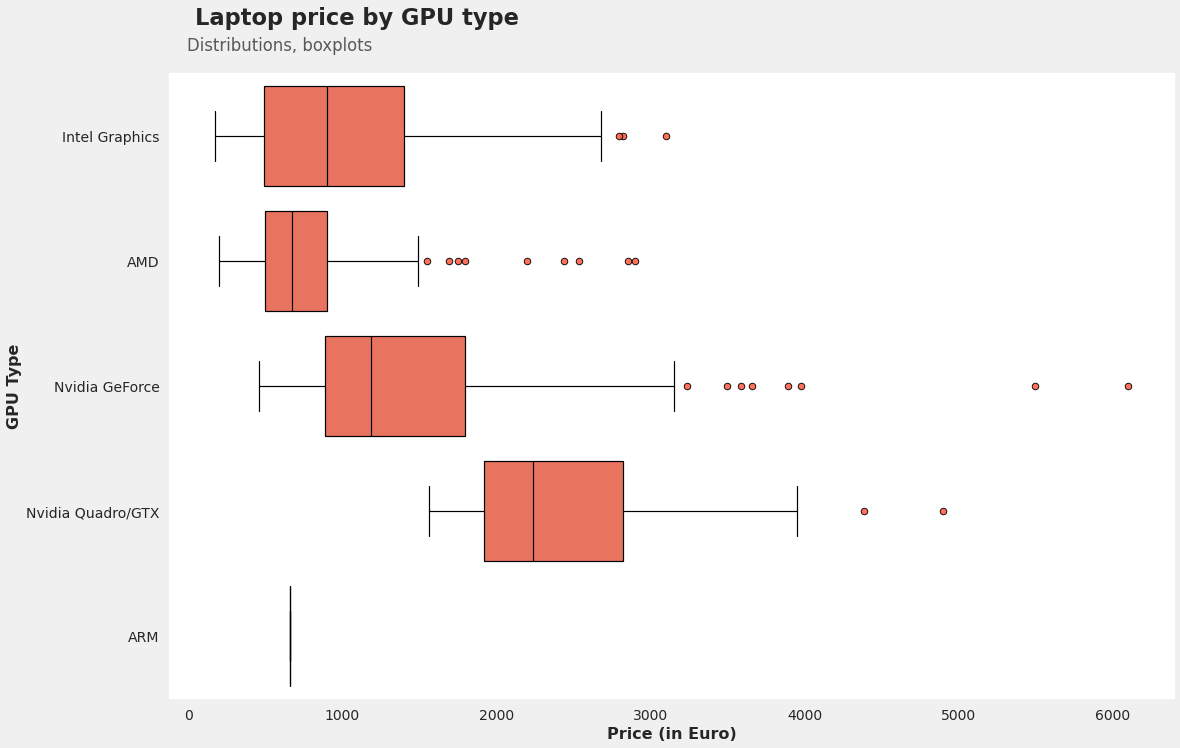

In [10]:
df['Gpu'] = df['Gpu'].replace(['Nvidia GeForce GTX 1050', 'Nvidia GeForce GTX 1060', 'Nvidia GeForce 940MX', 'Nvidia GeForce GTX 1070', 'Nvidia GeForce GTX 1050 Ti',
                               'Nvidia GeForce 930MX', 'Nvidia GeForce MX150', 'Nvidia GeForce GTX 960M', 'Nvidia GeForce 920MX', 'Nvidia GeForce GTX 980M', 'Nvidia GeForce GTX 950M',
                               'Nvidia GeForce 930M', 'Nvidia GeForce 920M', 'Nvidia GeForce MX130', 'Nvidia GeForce GTX 1080', 'Nvidia GeForce 920MX', 'Nvidia GeForce 930MX',
                               'Nvidia GeForce GTX 970M', 'Nvidia GeForce GT 940MX', 'Nvidia GeForce GTX 965M', 'Nvidia GeForce 920MX', 'Nvidia GeForce 930MX', 'Nvidia GeForce GTX 940MX',
                               'Nvidia GeForce GTX 1050M', 'Nvidia GeForce 150MX', 'Nvidia GeForce GTX 1050Ti', 'Nvidia GeForce GTX 960', 'Nvidia GeForce GTX 960<U+039C>',
                               'Nvidia GeForce GTX1050 Ti', 'Nvidia GeForce GTX1080', 'Nvidia GeForce 920', 'Nvidia GeForce GTX 980', 'Nvidia GeForce 930MX', 'Nvidia GeForce 960M',
                               'Nvidia GeForce 920MX', 'Nvidia GeForce 940M', 'Nvidia GeForce GTX 980', 'Nvidia GeForce GTX 1070M', 'Nvidia GeForce GTX 930MX', 'Nvidia GeForce GTX1060',
                               'Nvidia GeForce GTX 940M', 'Nvidia GeForce 930MX ', 'Nvidia GeForce 920MX', 'Nvidia GeForce GTX 980',  'Nvidia GeForce 920MX ', 'Nvidia GeForce GTX 980 '], 'Nvidia GeForce')
df['Gpu'] = df['Gpu'].replace(['Nvidia Quadro M1200', 'Nvidia Quadro M620', 'Nvidia Quadro M1000M', 'Nvidia Quadro M2200M', 'Nvidia Quadro M2200', 'Nvidia Quadro M520M', 
                               'Nvidia Quadro M2000M', 'Nvidia Quadro M3000M', 'Nvidia Quadro M620M', 'Nvidia GTX 980 SLI', 'Nvidia Quadro 3000M', 'Nvidia Quadro M500M'], 'Nvidia Quadro/GTX')
df['Gpu'] = df['Gpu'].replace(['Intel HD Graphics 620', 'Intel HD Graphics 520', 'Intel UHD Graphics 620', 'Intel HD Graphics 500', 'Intel HD Graphics 400', 'Intel Iris Graphics 540',
                               'Intel HD Graphics', 'Intel HD Graphics 515', 'Intel HD Graphics 615', 'Intel HD Graphics 505', 'Intel HD Graphics 405', 'Intel Iris Plus Graphics 640',
                               'Intel HD Graphics 6000', 'Intel HD Graphics 510', 'Intel HD Graphics 630', 'Intel HD Graphics 5300', 'Intel Iris Plus Graphics 650', 'Intel HD Graphics 620',
                               'Intel Iris Graphics 550', 'Intel Iris Pro Graphics', 'Intel Graphics 620', 'Intel HD Graphics 620', 'Intel HD Graphics 540', 'Intel HD Graphics 530', 
                               'Intel HD Graphics 620', 'Intel HD Graphics 620 '], 'Intel Graphics')
df['Gpu'] = df['Gpu'].replace(['AMD Radeon 530', 'AMD Radeon R5 M430', 'AMD Radeon 520', 'AMD Radeon R7 M445', 'AMD Radeon R5', 'AMD Radeon R5 M420', 'AMD Radeon R5 M330',
                               'AMD Radeon R2', 'AMD Radeon R4 Graphics', 'AMD Radeon RX 580', 'AMD Radeon R7 M440', 'AMD Radeon RX 550', 'AMD Radeon R2 Graphics', 'AMD Radeon R5 M420X',
                               'AMD Radeon R4', 'AMD Radeon RX 540', 'AMD Radeon R7 M460', 'AMD FirePro W4190M', 'AMD Radeon R7 M360', 'AMD Radeon 540', 'AMD FirePro W4190M',
                               'AMD Radeon R7 Graphics', 'AMD Radeon Pro 560', 'AMD Radeon R7', 'AMD Radeon RX 560', 'AMD Radeon Pro 455', 'AMD FirePro W6150M', 'AMD Radeon R3',
                               'AMD R4 Graphics', 'AMD Radeon Pro 555', 'AMD Radeon R5 430', 'AMD Radeon R7 M465', 'AMD R17M-M1-70', 'AMD Radeon R5 M315', 'AMD Radeon R7 M365X',
                               'AMD Radeon R9 M385', 'AMD FirePro W5130M', 'AMD Radeon R5 520', 'AMD FirePro W4190M '], 'AMD')
df['Gpu'] = df['Gpu'].replace(['ARM Mali T860 MP4'], 'ARM')


plot_box(x = "Price_euros", y = "Gpu", xlabel = 'Price (in Euro)', ylabel = "GPU Type", title = "Laptop price by GPU type",
         subtitle = "Distributions, boxplots", color = "tomato", title_position = 0.187, subtitle_position = 0.11)

<DIV align="justify">Now that we have a CPU, it's time for another very important component, the GPU. As with processors, we suspect a huge impact on the model, and we have a very large number of variable levels that require recoding to make the variables useful. We divide graphics cards into 4 types: Intel Graphics, i.e. built-in graphics from Windows, cards from AMD, Nvidia GeForce cards, other cards from Nvidia (mainly Quadro) and ARM, which has only one laptop. The most expensive latpots have Nvidia cards, mainly Quadro and new versions of GeForce, the cheapest are laptops with AMD graphics. The variable will affect the model, but due to grouping to simplify model construction, we lose a lot of information, but the variable seems to be very useful anyway.</DIV>

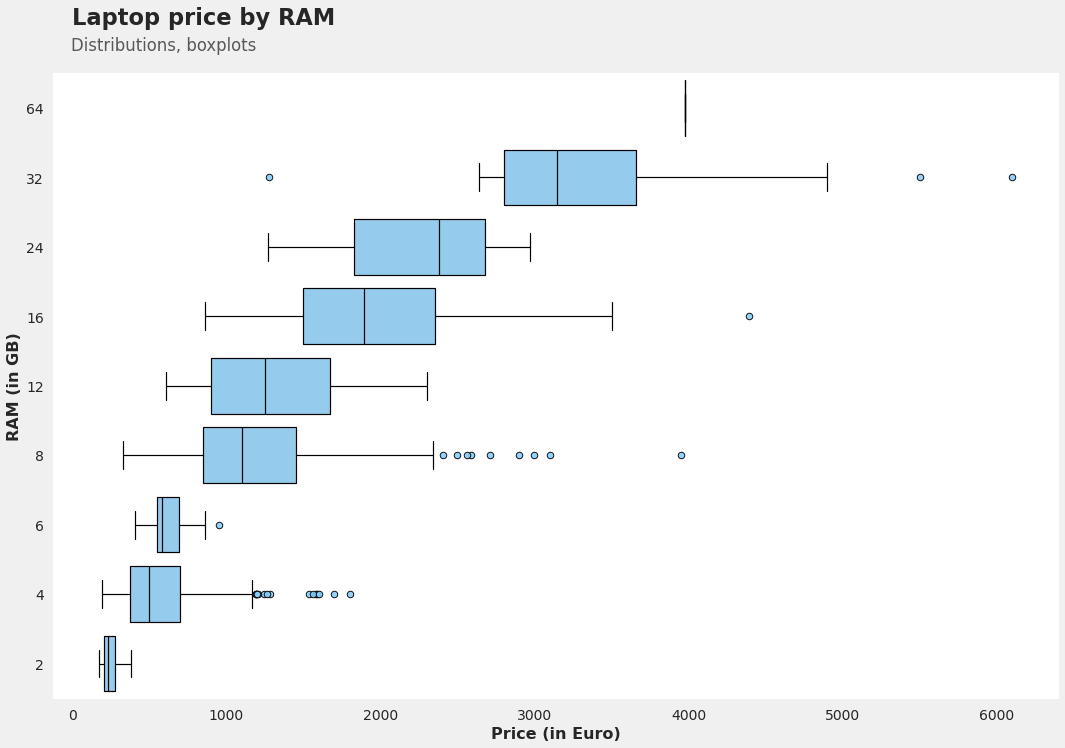

In [11]:
df["Ram"] = df["Ram"].str.replace('\D', '', regex=True)

plot_box(x = "Price_euros", y = "Ram", xlabel = 'Price (in Euro)', ylabel = "RAM (in GB)", title = "Laptop price by RAM",
         subtitle = "Distributions, boxplots", color = "lightskyblue", title_position = 0.15, subtitle_position = 0.11,
         order = ["64", "32", "24", "16", "12", "8", "6", "4", "2"])

df["Ram"] = df["Ram"].astype('int')

<DIV align="justify">We pass to RAM. It's a stimulant because the more RAM, the faster and more expensive the hardware. Database includes laptops with memory between 2 and 64 GB, which can be divided into 9 categories. A box plot was built for each of these categories and sorted in descending order. Conclusion leaves no doubt that as the amount of RAM decreases, the price of the laptop drops. We will not find any laptop costing over 2000 euros with less than 8 GB of RAM, but we will not find any laptop up to 2000 euros that would have more than 16 GB. So the variable will affect price, the question remains how much.</DIV>

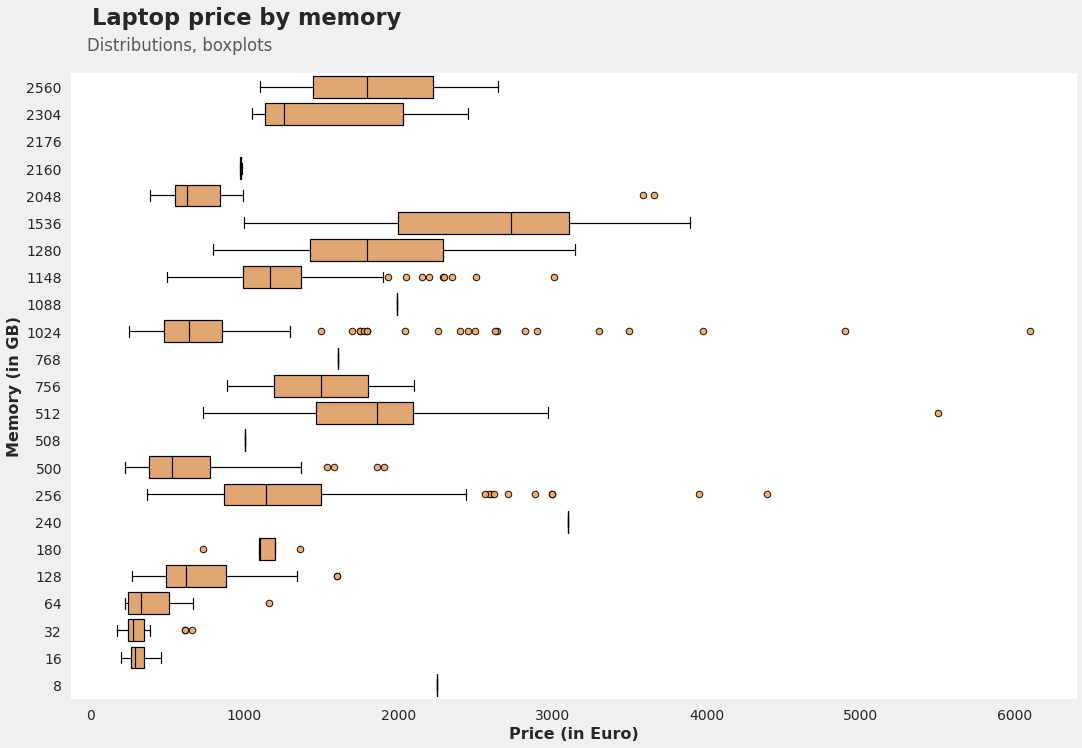

In [12]:
df['Memory'] = df['Memory'].replace(['128GB SSD', '128GB Flash Storage', '128GB HDD'], '128')
df['Memory'] = df['Memory'].replace(['256GB SSD', '256GB Flash Storage'], '256')
df['Memory'] = df['Memory'].replace(['512GB SSD', '256GB SSD +  256GB SSD', '512GB Flash Storage'], '512')
df['Memory'] = df['Memory'].replace(['500GB HDD'], '500')
df['Memory'] = df['Memory'].replace(['1TB HDD', '1TB SSD', '1.0TB Hybrid', '512GB SSD +  512GB SSD', '1.0TB HDD'], '1024')
df['Memory'] = df['Memory'].replace(['2TB HDD', '1TB SSD +  1TB HDD', '1TB HDD +  1TB HDD',], '2048')
df['Memory'] = df['Memory'].replace(['128GB SSD +  2TB HDD'], '2160')
df['Memory'] = df['Memory'].replace(['32GB Flash Storage', '32GB SSD', '32GB HDD'], '32')
df['Memory'] = df['Memory'].replace(['256GB SSD +  500GB HDD'], '756')
df['Memory'] = df['Memory'].replace(['16GB Flash Storage', '16GB SSD'], '16')
df['Memory'] = df['Memory'].replace(['128GB SSD +  1TB HDD'], '1148')
df['Memory'] = df['Memory'].replace(['64GB Flash Storage', '64GB SSD'], '64')
df['Memory'] = df['Memory'].replace(['180GB SSD'], '180')
df['Memory'] = df['Memory'].replace(['240GB SSD'], '240')
df['Memory'] = df['Memory'].replace(['512GB SSD +  256GB SSD'], '768')
df['Memory'] = df['Memory'].replace(['256GB SSD +  1TB HDD', '256GB SSD +  1.0TB Hybrid'], '1280')
df['Memory'] = df['Memory'].replace(['512GB SSD +  1TB HDD', '512GB SSD +  1.0TB Hybrid'], '1536')
df['Memory'] = df['Memory'].replace(['256GB SSD +  2TB HDD'], '2304')
df['Memory'] = df['Memory'].replace(['128GB SSD +  2TB HDD'], '2176')
df['Memory'] = df['Memory'].replace(['512GB SSD +  2TB HDD'], '2560')
df['Memory'] = df['Memory'].replace(['8GB SSD'], '8')
df['Memory'] = df['Memory'].replace(['508GB Hybrid'], '508')
df['Memory'] = df['Memory'].replace(['64GB Flash Storage +  1TB HDD'], '1088')

plot_box(x = "Price_euros", y = "Memory", xlabel = 'Price (in Euro)', ylabel = "Memory (in GB)", title = "Laptop price by memory",
         subtitle = "Distributions, boxplots", color = "sandybrown", title_position = 0.175, subtitle_position = 0.108,
         order = ["2560", "2304", "2176", "2160", "2048", "1536", "1280", "1148", "1088", "1024", "768", "756", "512", "508", "500", "256", "240", "180", "128", "64", "32", "16", "8"])

df["Memory"] = df["Memory"].astype('int')

<DIV align="justify">We process the next variable, memory saved on disks in the same way as RAM memory. For each device, we add up the total memory on the disks in each laptop (as some laptops have SSD and HDD disks simultaneously) and thus create a variable amount corresponding to the memory expressed in GB. The shooting is lightning - from 8GB up to 2.5TB of memory. The variable is certainly a stimulant - we want large values of this variable, which affects the price of the laptop. This is confirmed by the graph, but it is hard to say what the relationship is, because the "jumps" between the values are irregular. Most laptops have 1 TB or 256 GB of memory, and the variable seems to have a similar effect on modeling as RAM.</DIV>

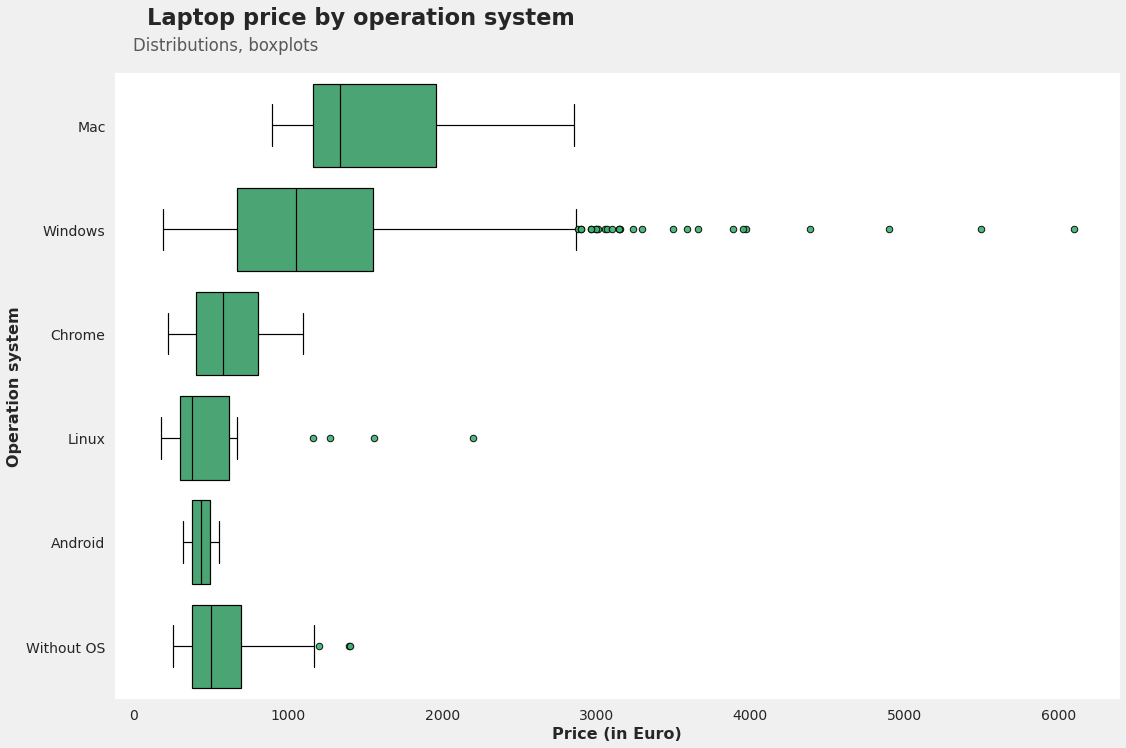

In [13]:
df['OpSys'] = np.select(
       [df['OpSys'].isin(["macOS", "Mac OS X"]), 
        df['OpSys'].isin(["Windows 10", "Windows 7", 'Windows 10 S']),
        df['OpSys'].isin(["Chrome OS"]),
        df['OpSys'].isin(["Linux"]),
        df['OpSys'].isin(["Android"]),
        df['OpSys'].isin(["No OS"])], 
        ['Mac', 'Windows', 'Linux', 'Chrome', 'Android', 'Without OS'], 
    default = 'Unknown')

plot_box(x = "Price_euros", y = "OpSys", xlabel = 'Price (in Euro)', ylabel = "Operation system", title = "Laptop price by operation system",
         subtitle = "Distributions, boxplots", color = "mediumseagreen", order = ['Mac', 'Windows', 'Chrome', 'Linux', 'Android', 'Without OS'],
         title_position = 0.245, subtitle_position = 0.11)

<DIV align="justify">Operating system will be the penultimate variable. The variable is grouped into 6 categories: Mac, Windows, Linux, Chrome, Android and Without OS, of which most laptops have Windows. For each of the categories, a box plot was prepared showing the price distribution. The highest median price is in laptops with the Mac operating system, and the lowest among laptops with Linux (interestingly even lower than in laptops without any system installed). Variable may affect the model, but rather to a small extent, as Windows laptops making up the majority of the population have a price distribution very similar to that of the overall population.</DIV>

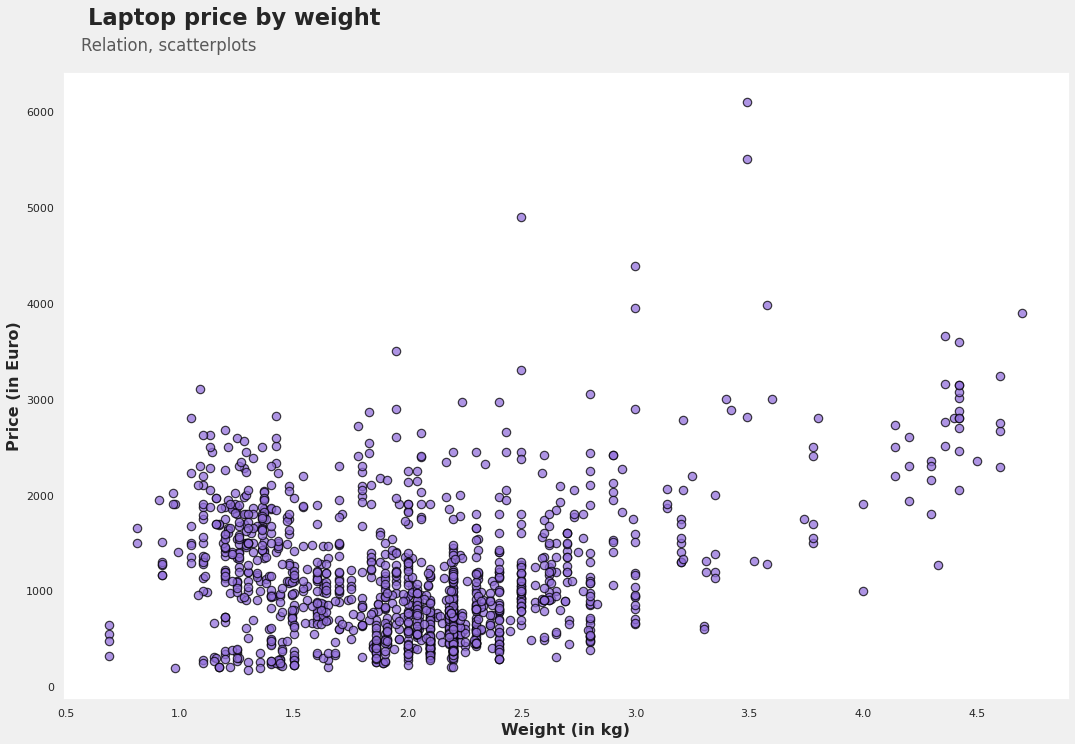

In [14]:
df["Weight"] = df["Weight"].str.extract('(\d*\.?\d*)', expand=False).astype(float)

plot_scatter(x = "Weight", y = "Price_euros", ylabel = 'Price (in Euro)', xlabel = "Weight (in kg)", title = "Laptop price by weight",
             subtitle = "Relation, scatterplots", color = "mediumpurple", title_position = 0.17, subtitle_position = 0.105, 
             size = 70, alpha = 0.75)

<DIV align="justify">Final variable will be the weight of the laptop. Basically, we want the laptop to be as light as possible, but good components such as a decent graphics card and disks make the laptop weigh more. So it's hard to tell if this change is a stimulant or you are a destimulant, so we create a scatter plot and compare the two quantitative characteristics. It's hard to find an obvious relationship between these features, but we can see that laptops over 3.5 kg (i.e. heavy) cost more than others. The cheapest laptops, usually weighing around 2 kg, are average weight. There is certainly no linear relationship here, the variable may have some influence on the price, but it seems that in connection with the first task, these may be apparent correlations.</DIV>

<DIV align="justify">Data has been pre-analyzed, so we move to the modeling stage. The model will be a neural network, and the entire process will be carried out using the Tensorflow and Keras packages. However, the data still requires some preparation to be useful for models - we recode categorical variables into l-1 binary variables, where l is the number of levels of the variable. These are dummy variables, for each level the value 1 appears when the laptop has the feature indicated in the new variable.</DIV>

In [15]:
df = df.drop(columns = ['laptop_ID', 'Product'])

df_dummy = pd.get_dummies(df, columns = ['Company', 'TypeName', "Inches", 'Cpu', 'Gpu', 'OpSys'])
df = df.merge(df_dummy, left_index = False, right_index = False)

df = df.drop(columns = ['Company', 'TypeName', "Inches", 'Cpu', 'Gpu', 'OpSys'])
print("Shapes of model database: ", df.shape)

Shapes of model database:  (1415, 51)


<DIV align="justify">The model data includes 1415 lines and 51 variables (50 explained in a quantitative or zero-one form and an explanatory price). A small number of lines seems to be a serious problem whether the algorithm will manage to learn dependencies in the database on such a small sample. We move on to the division of the set into training and testing.</DIV>

In [16]:
X = df.drop(columns = ['Price_euros'])
Y = df['Price_euros']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)

<DIV align="justify">We divide the set in the proportion 3:1 (75% of cases are randomly placed in the training set, and the remaining 25% is the test set). The training set created in this way has 1061 lines and the test set has 354 lines. We then proceed to create a neural network.</DIV>

In [17]:
np.random.seed(123)

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def create_model(learn_rate = 0.01, activation = 'relu', neurons = 1):
    model = Sequential()
    model.add(Dense(neurons, input_dim = len(X_train.columns), kernel_initializer = 'normal', activation = activation))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1))
    opt = keras.optimizers.Adam(learning_rate = learn_rate)
    model.compile(loss = root_mean_squared_error, optimizer = 'adam')
    return model

<DIV align="justify">We want our neural network model to minimize the error, which will be the root mean square error. It doesn't have a defined function, so we create it ourselves. Then we create a network structure. We set the learning rate, the activation function and the number of neurons in the first layer as variables that we will then optimize. The network itself will have an input layer, one hidden layer with 10 neurons and a relu active function, and the last layer with 1 neuron. The whole structure is closed in a function and the first variables are set.</DIV>

In [18]:
model = KerasRegressor(build_fn = create_model, verbose = 0)

batch_size = [1, 10, 40, 100]
learn_rate = [0.0001, 0.001, 0.01, 0.05]
activation = ['relu', 'tanh', 'sigmoid']
neurons = [32, 16, 256]

param_grid = dict(batch_size = batch_size, learn_rate = learn_rate, activation = activation, neurons = neurons)
grid = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs = -1, cv = 5)

<DIV align="justify">For the created function we run GridSearch to minimize errors in the last model. We will be looking for 4 optimal parameters: batch size, learning rate, activation function in the 1st layer and the number of neurons in the 1st layer. Arguments will be searched in such a way as to minimize the RMSE from a 3-fold cross-validation.</DIV>

In [21]:
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -410.206335 using {'activation': 'relu', 'batch_size': 1, 'learn_rate': 0.05, 'neurons': 256}


<DIV align="justify">We used a parameter search on our network structure. The best model turned out to be the one in which the batch size was 1, the learning rate was 0.05, and in the first layer, relu activation function was represented by 256 neurons. The root mean square error for this function was around 410 euros.</DIV>

In [22]:
model = Sequential()
model.add(Dense(256, input_dim = len(X_train.columns), kernel_initializer = 'normal', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate = 0.05)
model.compile(loss = root_mean_squared_error, optimizer = 'adam')

<DIV align="justify">We create the final model according to the previously designed network, taking into account the best parameters. For the optimizer we use the "adam" algorithm.</DIV>

In [23]:
callbacks = [keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 15, verbose = 1)]

history = model.fit(X_train, y_train, epochs = 500, batch_size = 1, validation_split = 0.25, verbose = 0, callbacks = callbacks)

Epoch 00090: early stopping


<DIV align="justify">We adjust the model to the training data. Additionally, we create a validation set by randomizing 25% of cases from the training set. It will have a bug-test for each epoch to know when to quit learning. Learning will end when the algorithm fails to improve for 15 epochs (maximum 500). It turns out that the model finished training after 90 epochs thus optimizing one more hyperparameter.</DIV>

In [24]:
mse_train = model.evaluate(X_train, y_train, verbose = 0)
print("RMSE on train set (in €): " + str(round(mse_train, 0)))

RMSE on train set (in €): 327.0


<DIV align="justify">At the beginning, we check how the model is doing on the test set. We compare the actual price with the forecast price and calculate the RMSE. It amounts to 359 euros, which means that on the training set, the model forecasts price of the laptop with an average error of 327.</DIV>

In [25]:
y_pred = model.predict(X_test)

mse_test = mean_squared_error(y_pred, y_test)
print("RMSE on test set (in €): ", str(round(mse_test**0.5, 0)))

RMSE on test set (in €):  389.0


<DIV align="justify">However, the error on the training set is not objective, because the model had information about real prices in the learning process, therefore we project the model to the test set. We compare the actual price on this set with the forecast price (which the model has not seen before) and recalculate the RMSE. It amounts to 389 euros, which means that on the test set, the model pedicts price of the laptop with an average error of 389.</DIV>

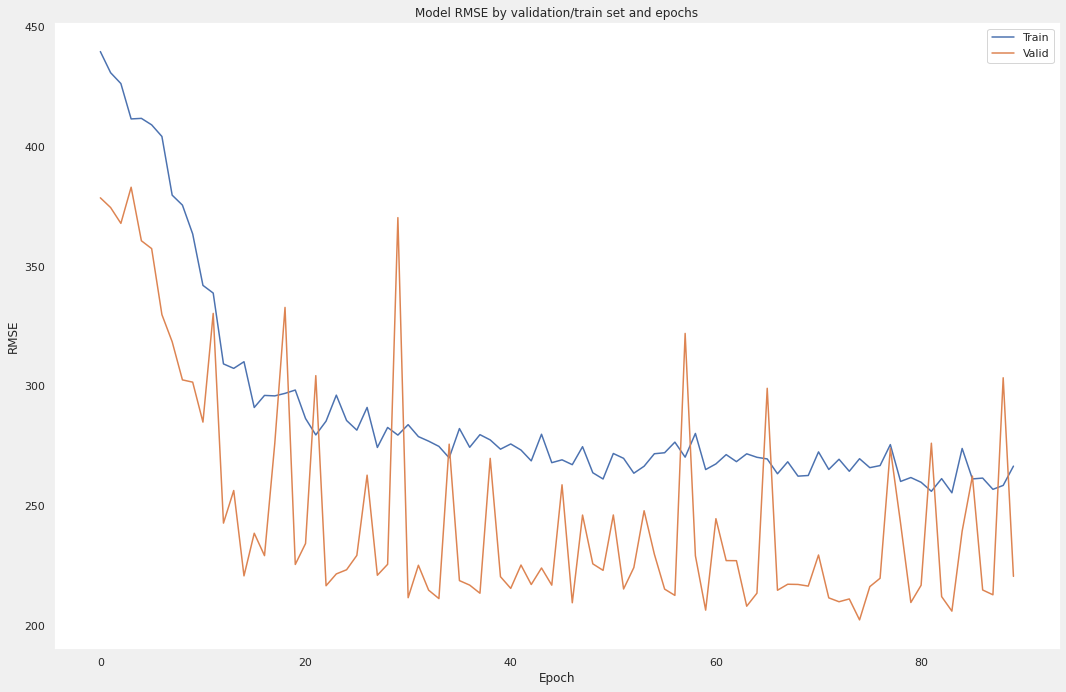

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model RMSE by validation/train set and epochs')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc = 'upper right')
plt.show()

<DIV align="justify">With the addition of subsequent epochs, RMSE both on the training and validation set decreases, but at around 10 epochs it begins to clearly begin to stabilize and behave unnaturally on the validation set. The errors on the training and validation set reach very similar values, therefore we conclude that the algorithm is not very overfitted.</DIV>

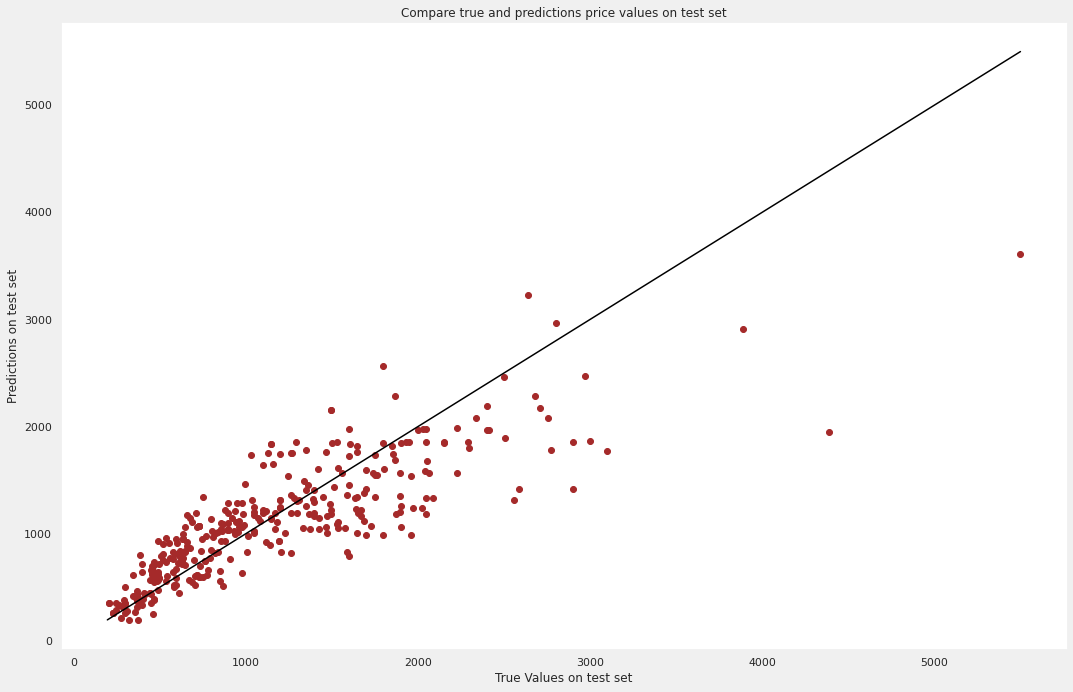

In [27]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 
p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'black')

plt.scatter(y_test, y_pred, c = "brown")
plt.title('Compare true and predictions price values on test set')
plt.xlabel('True Values on test set')
plt.ylabel('Predictions on test set')
plt.show()

<DIV align="justify">Next, we check the model results on the test set in a graphic form. On the X axis, we present the real values, and on the Y axis, the values calculated by the model, while the black line is a perfect match. We can see that all the points (the specific laptops that hit the test set are near the black line to change over and under, which means that the model does not tend to overestimate or underestimate the value.</DIV>

In [28]:
perm = PermutationImportance(model, scoring = 'neg_root_mean_squared_error', random_state = 123).fit(X_train, y_train)
eli5.explain_weights(perm, feature_names = X_train.columns.tolist(), top = 50)

Weight,Feature
229.9916 ± 21.9454,Ram
87.7826 ± 8.0379,ScreenHeight
13.3965 ± 2.1677,TypeName_Notebook
10.9859 ± 3.2321,Cpu_Intel Core i7
10.8398 ± 2.9278,ScreenWidth
10.6338 ± 2.1658,Memory
8.0628 ± 1.3552,Gpu_Nvidia Quadro/GTX
7.4337 ± 2.2813,Cpu_Intel Other
5.5862 ± 1.1463,TypeName_Ultrabook
4.7913 ± 1.5714,TypeName_Workstation


<DIV align="justify">Finally, we check the influence of variables on the model. They are presented as mean weights for each variable along with their standard deviation. We can see that RAM has proved to be the most influential variable. Screen resolution (pixel height) and hard memory also had a significant impact on the model. Some of the variables indicating specific models and operating systems turned out to be of no use for the model. The CPU and GPU and their categorized form turned out to have a relatively small impact (although quite high on the list, the relative impact on the model is small).</DIV>

<DIV align="justify">After the expansion analysis and the construction of a neural network explaining the price of a laptop based on its components, we can draw the following conclusions:</DIV>

* On average, the most expensive laptop brand is Razer and the most popular is Dell and Lenovo,

* Among the types of equipment, the notebook is the most popular, while gaming equipment and workstations are the most expensive,

* Size of the laptop screen is neither stimulant nor destimulant, as on average laptops with a medium-sized screen (between 14 and 16 inches) have the lowest price,

* Basically, the higher the screen resolution, the higher the price for a laptop, and by far the most popular resolution is FullHD 16:9,

* On average, the most expensive laptops have a 7th generation Intel Core processor, while the cheapest ones have the old version of Intel or Intel Core i3 processors and AMD processors,

* Most graphics cards are manufactured by Nvidia and usually have the highest prices, while many devices do not have a graphics card and use graphics from Intel,

* RAM definitely affects the model - the greater its amount expressed in GB, the more expensive the laptop's price,

* A similar relationship to the one mentioned above applies to hard memory, but the tendency is not so clearly visible there,

* Operating system has a relatively low impact on the prices of the laptop as the most expensive average laptops have Mac OS (but the most expensive laptops have Windows),

* There is no clear correlation between the weight and price of a laptop, but the heaviest laptops tend to be expensive in terms of their components,

* Model database contains 1415 rows and 51 columns, 1/4 of which was allocated to the test set and the remaining 75% to the validation training set (also divided in the proportion of 3 to 1),

* Neural network model has been optimized with regard to the following parameters: activation function w and number of neutrons in 1 value, learning rate and batch size and number of epochs,

* Mean error (RMSE) on the training set was 383 euros and on the test set 441 euros, and the model was not over-learned in the learning process,

* Most influential variables in the model turned out to be RAM, screen resolution and hard memory.

Sources:
1. https://stackoverflow.com/questions/43434020/black-and-white-boxplots-in-seaborn
2. https://seaborn.pydata.org/index.html
3. https://stackoverflow.com/questions/5254445/add-string-in-a-certain-position-in-python
4. https://stackoverflow.com/questions/49228596/pandas-case-when-default-in-pandas
5. https://towardsdatascience.com/the-dummys-guide-to-creating-dummy-variables-f21faddb1d40
6. https://www.kaggle.com/diegosiebra/neural-network-model-for-house-prices-keras
7. https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
8. https://towardsdatascience.com/building-our-first-neural-network-in-keras-bdc8abbc17f5
9. https://www.youtube.com/watch?v=qFJeN9V1ZsI
10. https://www.tensorflow.org/guide/keras/train_and_evaluate
11. https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
12. https://www.kaggle.com/dansbecker/permutation-importance

**Thanks for reading my kernal!**

**If you have any suggestions for improving the analysis, let me know in the comment!**

**If you liked my kernel, give upvote!**

**If you have a moment, I encourage you to see at my other [projects](https://www.kaggle.com/michau96/code).**